In [46]:
import logging
import logging
import os
import pathlib
import pickle
import zipfile
from pathlib import Path
import joblib

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import yaml
from sklearn.preprocessing import OneHotEncoder
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from dataloader import load_graph_adj_mtx, load_graph_node_features
from model import GCN, GCN_2, GCN_3, GIN, NodeAttnMap, NodeAttnMap_2, UserEmbeddings, Time2Vec, CategoryEmbeddings, FuseEmbeddings, TransformerModel, GatedFusion, TransformerModel_5
from param_parser import parameter_parser
from utils import increment_path, calculate_laplacian_matrix, zipdir, top_k_acc_last_timestep, \
    mAP_metric_last_timestep, MRR_metric_last_timestep, maksed_mse_loss

In [14]:
state_dict = torch.load("/root/root/GETNext/runs/train/exp47/checkpoints/best_epoch.state.pt")
print(state_dict.keys())
args = state_dict['args']
data_test = "dataset/NYC/NYC_test.csv"

dict_keys(['epoch', 'poi_embed_state_dict', 'node_attn_state_dict', 'user_embed_state_dict', 'time_embed_state_dict', 'cat_embed_state_dict', 'embed_fuse1_state_dict', 'embed_fuse2_state_dict', 'seq_model_state_dict', 'optimizer_state_dict', 'user_id2idx_dict', 'poi_id2idx_dict', 'cat_id2idx_dict', 'poi_idx2cat_idx_dict', 'node_attn_map', 'args', 'epoch_train_metrics', 'epoch_val_metrics'])


In [15]:
print(args)

Namespace(batch=16, cat_embed_dim=32, data_adj_mtx='dataset/NYC/graph_A.csv', data_node_feats='dataset/NYC/graph_X.csv', data_train='dataset/NYC/NYC_train.csv', data_val='dataset/NYC/NYC_val.csv', device=device(type='cuda'), epochs=200, exist_ok=False, feature1='checkin_cnt', feature2='poi_catid', feature3='latitude', feature4='longitude', gcn_dropout=0.3, gcn_nfeat=316, gcn_nhid=[32, 64], lr=0.001, lr_scheduler_factor=0.1, mode='client', name='exp47', no_cuda=False, node_attn_nhid=128, poi_embed_dim=128, port=64973, project='runs/train', save_dir='runs/train/exp47', save_embeds=False, save_weights=True, seed=42, seq_input_embed=320, short_traj_thres=2, time_embed_dim=32, time_feature='norm_in_day_time', time_loss_weight=10, time_units=48, transformer_dropout=0.3, transformer_nhead=4, transformer_nhid=1024, transformer_nlayers=2, user_embed_dim=128, weight_decay=0.01, workers=0)


In [16]:
# %% ====================== Load data ======================
# Read check-in train data
train_df = pd.read_csv(args.data_train)
val_df = pd.read_csv(data_test)

# Build POI graph (built from train_df)
print('Loading POI graph...')
raw_A = load_graph_adj_mtx(args.data_adj_mtx)
raw_X = load_graph_node_features(args.data_node_feats,
                                 args.feature1,
                                 args.feature2,
                                 args.feature3,
                                 args.feature4)
num_pois = raw_X.shape[0]
one_hot_encoder = joblib.load("/root/root/GETNext/runs/train/exp47/one-hot-encoder.pkl")
cat_list = list(raw_X[:, 1])
one_hot_rlt = one_hot_encoder.transform(list(map(lambda x: [x], cat_list))).toarray()
num_cats = one_hot_rlt.shape[-1]
X = np.zeros((num_pois, raw_X.shape[-1] - 1 + num_cats), dtype=np.float32)
X[:, 0] = raw_X[:, 0]
X[:, 1:num_cats + 1] = one_hot_rlt
X[:, num_cats + 1:] = raw_X[:, 2:]

# Normalization
print('Laplician matrix...')
# raw_A_undirect = (raw_A + raw_A.T) / 2
# A = calculate_laplacian_matrix(raw_A_undirect, mat_type='hat_rw_normd_lap_mat')
# raw_A_undirect = np.maximum(raw_A, raw_A.T)
# A = calculate_laplacian_matrix(raw_A_undirect, mat_type='hat_rw_normd_lap_mat')
# A = calculate_laplacian_matrix(raw_A, mat_type='hat_rw_normd_lap_mat')
# A = calculate_laplacian_matrix(raw_A_undirect, mat_type='com_lap_mat')

raw_A_undirect = (raw_A + raw_A.T) / 2
A = calculate_laplacian_matrix(raw_A_undirect, mat_type='hat_rw_normd_lap_mat')
A_dir = calculate_laplacian_matrix(raw_A, mat_type='hat_rw_normd_lap_mat')

# POI id to index
poi_id2idx_dict = state_dict['poi_id2idx_dict']

# Cat id to index
cat_id2idx_dict = state_dict['cat_id2idx_dict']

# Poi idx to cat idx
poi_idx2cat_idx_dict = state_dict['poi_idx2cat_idx_dict']

# User id to index
user_id2idx_dict = state_dict['user_id2idx_dict']

# Print user-trajectories count
traj_list = list(set(train_df['trajectory_id'].tolist()))

Loading POI graph...
Laplician matrix...


In [102]:
# raw_A_undirect = np.maximum(raw_A, raw_A.T)
# A_undirect = calculate_laplacian_matrix(raw_A_undirect, mat_type='com_lap_mat')
# raw_A_undirect = (raw_A + raw_A.T) / 2
# A = calculate_laplacian_matrix(raw_A_undirect, mat_type='hat_rw_normd_lap_mat')
# raw_A_undirect = (raw_A + raw_A.T) / 2
# print(raw_A_undirect)
# print(np.max(np.abs(A_undirect), axis=-1))
# A_undirect = A_undirect / np.sum(A_undirect, axis=1)
# print(A_undirect / np.max(np.abs(A_undirect), axis=-1))

In [17]:
class TrajectoryDatasetVal(Dataset):
    def __init__(self, df):
        self.df = df
        self.traj_seqs = []
        self.input_seqs = []
        self.label_seqs = []

        for traj_id in tqdm(set(df['trajectory_id'].tolist())):
            user_id = traj_id.split('_')[0]

            # Ignore user if not in training set
            if user_id not in user_id2idx_dict.keys():
                continue

            # Ger POIs idx in this trajectory
            traj_df = df[df['trajectory_id'] == traj_id]
            poi_ids = traj_df['POI_id'].to_list()
            poi_idxs = []
            time_feature = traj_df[args.time_feature].to_list()

            for each in poi_ids:
                if each in poi_id2idx_dict.keys():
                    poi_idxs.append(poi_id2idx_dict[each])
                else:
                    # Ignore poi if not in training set
                    continue

            # Construct input seq and label seq
            input_seq = []
            label_seq = []
            for i in range(len(poi_idxs) - 1):
                input_seq.append((poi_idxs[i], time_feature[i]))
                label_seq.append((poi_idxs[i + 1], time_feature[i + 1]))

            # Ignore seq if too short
            if len(input_seq) < args.short_traj_thres:
                continue

            self.input_seqs.append(input_seq)
            self.label_seqs.append(label_seq)
            self.traj_seqs.append(traj_id)

    def __len__(self):
        assert len(self.input_seqs) == len(self.label_seqs) == len(self.traj_seqs)
        return len(self.traj_seqs)

    def __getitem__(self, index):
        return (self.traj_seqs[index], self.input_seqs[index], self.label_seqs[index])

In [18]:
val_dataset = TrajectoryDatasetVal(val_df)

val_loader = DataLoader(val_dataset,
                            batch_size=args.batch,
                            shuffle=False, drop_last=False,
                            pin_memory=True, num_workers=args.workers,
                            collate_fn=lambda x: x)

100%|██████████| 1566/1566 [00:01<00:00, 1049.27it/s]


In [19]:
# %% ====================== Build Models ======================
# Model1: POI embedding model
# if isinstance(X, np.ndarray):
#     X = torch.from_numpy(X)
#     A = torch.from_numpy(A)
# X = X.to(device=args.device, dtype=torch.float)
# A = A.to(device=args.device, dtype=torch.float)

if isinstance(X, np.ndarray):
        X = torch.from_numpy(X)
        A = torch.from_numpy(A)
        A_dir = torch.from_numpy(A_dir)
X = X.to(device=args.device, dtype=torch.float)
A = A.to(device=args.device, dtype=torch.float)
A_dir = A_dir.to(device=args.device, dtype=torch.float)

args.gcn_nfeat = X.shape[1]
poi_embed_model = GCN(ninput=args.gcn_nfeat,
                      nhid=args.gcn_nhid,
                      noutput=args.poi_embed_dim,
                      dropout=args.gcn_dropout)
# poi_embed_model = GIN(ninput=args.gcn_nfeat,
#                       nhid=args.gcn_nhid,
#                       noutput=args.poi_embed_dim,
#                       dropout=args.gcn_dropout)

# Node Attn Model
node_attn_model = NodeAttnMap(in_features=X.shape[1], nhid=args.node_attn_nhid, use_mask=False)

# %% Model2: User embedding model, nn.embedding
num_users = len(user_id2idx_dict)
user_embed_model = UserEmbeddings(num_users, args.user_embed_dim)

# %% Model3: Time Model
time_embed_model = Time2Vec('sin', out_dim=args.time_embed_dim)

# %% Model4: Category embedding model
cat_embed_model = CategoryEmbeddings(num_cats, args.cat_embed_dim)

# %% Model5: Embedding fusion models
embed_fuse_model1 = FuseEmbeddings(args.user_embed_dim, args.poi_embed_dim)
embed_fuse_model2 = FuseEmbeddings(args.time_embed_dim, args.cat_embed_dim)

# embed_fuse_model1 = GatedFusion(args.user_embed_dim, args.poi_embed_dim)
# embed_fuse_model2 = GatedFusion(args.time_embed_dim, args.cat_embed_dim)
# embed_fuse_model3 = FuseEmbeddings(args.user_embed_dim, args.cat_embed_dim)
# embed_fuse_model1 = FuseEmbeddings_3(args.user_embed_dim, args.poi_embed_dim)
# embed_fuse_model2 = FuseEmbeddings_3(args.time_embed_dim, args.cat_embed_dim)
# embed_fuse_model1 = FuseEmbeddingsDrop(args.user_embed_dim, args.poi_embed_dim)
# embed_fuse_model2 = FuseEmbeddingsDrop(args.time_embed_dim, args.cat_embed_dim)
# embed_fuse_model1 = FuseEmbeddingsBilinear(args.user_embed_dim, args.poi_embed_dim)
# embed_fuse_model2 = FuseEmbeddingsBilinear(args.time_embed_dim, args.cat_embed_dim)

# %% Model6: Sequence model
args.seq_input_embed = args.poi_embed_dim + args.user_embed_dim + args.time_embed_dim + args.cat_embed_dim
# args.seq_input_embed = args.poi_embed_dim + args.cat_embed_dim
# args.seq_input_embed = args.poi_embed_dim + 2 * args.user_embed_dim + args.time_embed_dim + 2 * args.cat_embed_dim
seq_model = TransformerModel(num_pois,
                             num_cats,
                             args.seq_input_embed,
                             args.transformer_nhead,
                             args.transformer_nhid,
                             args.transformer_nlayers,
                             dropout=args.transformer_dropout)

In [20]:
criterion_poi = nn.CrossEntropyLoss(ignore_index=-1)  # -1 is padding
criterion_cat = nn.CrossEntropyLoss(ignore_index=-1)  # -1 is padding
criterion_time = maksed_mse_loss

In [21]:
def input_traj_to_embeddings(sample, poi_embeddings):
    # Parse sample
    traj_id = sample[0]
    input_seq = [each[0] for each in sample[1]]
    input_seq_time = [each[1] for each in sample[1]]
    input_seq_cat = [poi_idx2cat_idx_dict[each] for each in input_seq]

    # User to embedding
    user_id = traj_id.split('_')[0]
    user_idx = user_id2idx_dict[user_id]
    input = torch.LongTensor([user_idx]).to(device=args.device)
    user_embedding = user_embed_model(input)
    user_embedding = torch.squeeze(user_embedding)

    # POI to embedding and fuse embeddings
    input_seq_embed = []
    for idx in range(len(input_seq)):
        poi_embedding = poi_embeddings[input_seq[idx]]
        poi_embedding = torch.squeeze(poi_embedding).to(device=args.device)

        # Time to vector
        time_embedding = time_embed_model(
            torch.tensor([input_seq_time[idx]], dtype=torch.float).to(device=args.device))
        time_embedding = torch.squeeze(time_embedding).to(device=args.device)

        # Categroy to embedding
        cat_idx = torch.LongTensor([input_seq_cat[idx]]).to(device=args.device)
        cat_embedding = cat_embed_model(cat_idx)
        cat_embedding = torch.squeeze(cat_embedding)

        # Fuse user+poi embeds
        fused_embedding1 = embed_fuse_model1(user_embedding, poi_embedding)
        fused_embedding2 = embed_fuse_model2(time_embedding, cat_embedding)
        # fused_embedding3 = embed_fuse_model3(user_embedding, cat_embedding)

        # Concat time, cat after user+poi
        concat_embedding = torch.cat((fused_embedding1, fused_embedding2), dim=-1)

        # Save final embed
        input_seq_embed.append(concat_embedding)

    return input_seq_embed

def adjust_pred_prob_by_graph(y_pred_poi):
    y_pred_poi_adjusted = torch.zeros_like(y_pred_poi)
    # attn_map = node_attn_model(X, A)
    attn_map = node_attn_model(X, A_dir)

    for i in range(len(batch_seq_lens)):
        traj_i_input = batch_input_seqs[i]  # list of input check-in pois
        for j in range(len(traj_i_input)):
            y_pred_poi_adjusted[i, j, :] = attn_map[traj_i_input[j], :] + y_pred_poi[i, j, :]

    return y_pred_poi_adjusted

In [11]:
attn_map = node_attn_model(X, A_dir)
print(attn_map.shape)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat2 in method wrapper_mm)

In [22]:
poi_embed_model = poi_embed_model.to(device=args.device)
node_attn_model = node_attn_model.to(device=args.device)
user_embed_model = user_embed_model.to(device=args.device)
time_embed_model = time_embed_model.to(device=args.device)
cat_embed_model = cat_embed_model.to(device=args.device)
embed_fuse_model1 = embed_fuse_model1.to(device=args.device)
embed_fuse_model2 = embed_fuse_model2.to(device=args.device)
# embed_fuse_model3 = embed_fuse_model3.to(device=args.device)
seq_model = seq_model.to(device=args.device)

poi_embed_model.load_state_dict(state_dict['poi_embed_state_dict'])
node_attn_model.load_state_dict(state_dict['node_attn_state_dict'])
user_embed_model.load_state_dict(state_dict['user_embed_state_dict'])
time_embed_model.load_state_dict(state_dict['time_embed_state_dict'])
cat_embed_model.load_state_dict(state_dict['cat_embed_state_dict'])
embed_fuse_model1.load_state_dict(state_dict['embed_fuse1_state_dict'])
embed_fuse_model2.load_state_dict(state_dict['embed_fuse2_state_dict'])
# embed_fuse_model3.load_state_dict(state_dict['embed_fuse3_state_dict'])
seq_model.load_state_dict(state_dict['seq_model_state_dict'])

<All keys matched successfully>

In [23]:
poi_embed_model.eval()
node_attn_model.eval()
user_embed_model.eval()
time_embed_model.eval()
cat_embed_model.eval()
embed_fuse_model1.eval()
embed_fuse_model2.eval()
# embed_fuse_model3.eval()
seq_model.eval()

val_batches_top1_acc_list = []
val_batches_top5_acc_list = []
val_batches_top10_acc_list = []
val_batches_top20_acc_list = []
val_batches_mAP20_list = []
val_batches_mrr_list = []
val_batches_loss_list = []
val_batches_poi_loss_list = []
val_batches_time_loss_list = []
val_batches_cat_loss_list = []
src_mask = seq_model.generate_square_subsequent_mask(args.batch).to(args.device)
for vb_idx, batch in enumerate(val_loader):
    if len(batch) != args.batch:
        src_mask = seq_model.generate_square_subsequent_mask(len(batch)).to(args.device)

    # For padding
    batch_input_seqs = []
    batch_seq_lens = []
    batch_seq_embeds = []
    batch_seq_labels_poi = []
    batch_seq_labels_time = []
    batch_seq_labels_cat = []

    poi_embeddings = poi_embed_model(X, A)

    # Convert input seq to embeddings
    for sample in batch:
        traj_id = sample[0]
        input_seq = [each[0] for each in sample[1]]
        label_seq = [each[0] for each in sample[2]]
        input_seq_time = [each[1] for each in sample[1]]
        label_seq_time = [each[1] for each in sample[2]]
        label_seq_cats = [poi_idx2cat_idx_dict[each] for each in label_seq]
        input_seq_embed = torch.stack(input_traj_to_embeddings(sample, poi_embeddings))
        batch_seq_embeds.append(input_seq_embed)
        batch_seq_lens.append(len(input_seq))
        batch_input_seqs.append(input_seq)
        batch_seq_labels_poi.append(torch.LongTensor(label_seq))
        batch_seq_labels_time.append(torch.FloatTensor(label_seq_time))
        batch_seq_labels_cat.append(torch.LongTensor(label_seq_cats))

    # Pad seqs for batch training
    batch_padded = pad_sequence(batch_seq_embeds, batch_first=True, padding_value=-1)
    label_padded_poi = pad_sequence(batch_seq_labels_poi, batch_first=True, padding_value=-1)
    label_padded_time = pad_sequence(batch_seq_labels_time, batch_first=True, padding_value=-1)
    label_padded_cat = pad_sequence(batch_seq_labels_cat, batch_first=True, padding_value=-1)

    # Feedforward
    x = batch_padded.to(device=args.device, dtype=torch.float)
    y_poi = label_padded_poi.to(device=args.device, dtype=torch.long)
    y_time = label_padded_time.to(device=args.device, dtype=torch.float)
    y_cat = label_padded_cat.to(device=args.device, dtype=torch.long)
    y_pred_poi, y_pred_time, y_pred_cat = seq_model(x, src_mask)
    # print(y_pred_poi.shape)

    # Graph Attention adjusted prob
    y_pred_poi_adjusted = adjust_pred_prob_by_graph(y_pred_poi)

    # Calculate loss
    loss_poi = criterion_poi(y_pred_poi_adjusted.transpose(1, 2), y_poi)
    loss_time = criterion_time(torch.squeeze(y_pred_time), y_time)
    loss_cat = criterion_cat(y_pred_cat.transpose(1, 2), y_cat)
    loss = loss_poi + loss_time * args.time_loss_weight + loss_cat

    # Performance measurement
    top1_acc = 0
    top5_acc = 0
    top10_acc = 0
    top20_acc = 0
    mAP20 = 0
    mrr = 0
    batch_label_pois = y_poi.detach().cpu().numpy()
    batch_pred_pois = y_pred_poi_adjusted.detach().cpu().numpy()
    batch_pred_times = y_pred_time.detach().cpu().numpy()
    batch_pred_cats = y_pred_cat.detach().cpu().numpy()
    for label_pois, pred_pois, seq_len in zip(batch_label_pois, batch_pred_pois, batch_seq_lens):
        label_pois = label_pois[:seq_len]  # shape: (seq_len, )
        pred_pois = pred_pois[:seq_len, :]  # shape: (seq_len, num_poi)
        top1_acc += top_k_acc_last_timestep(label_pois, pred_pois, k=1)
        top5_acc += top_k_acc_last_timestep(label_pois, pred_pois, k=5)
        top10_acc += top_k_acc_last_timestep(label_pois, pred_pois, k=10)
        top20_acc += top_k_acc_last_timestep(label_pois, pred_pois, k=20)
        mAP20 += mAP_metric_last_timestep(label_pois, pred_pois, k=20)
        mrr += MRR_metric_last_timestep(label_pois, pred_pois)
    val_batches_top1_acc_list.append(top1_acc / len(batch_label_pois))
    val_batches_top5_acc_list.append(top5_acc / len(batch_label_pois))
    val_batches_top10_acc_list.append(top10_acc / len(batch_label_pois))
    val_batches_top20_acc_list.append(top20_acc / len(batch_label_pois))
    val_batches_mAP20_list.append(mAP20 / len(batch_label_pois))
    val_batches_mrr_list.append(mrr / len(batch_label_pois))
    val_batches_loss_list.append(loss.detach().cpu().numpy())
    val_batches_poi_loss_list.append(loss_poi.detach().cpu().numpy())
    val_batches_time_loss_list.append(loss_time.detach().cpu().numpy())
    val_batches_cat_loss_list.append(loss_cat.detach().cpu().numpy())

In [24]:
print("Top 1 acc", np.mean(val_batches_top1_acc_list))
print("Top 5 acc", np.mean(val_batches_top5_acc_list))
print("Top 10 acc", np.mean(val_batches_top10_acc_list))
print("Top 20 acc", np.mean(val_batches_top20_acc_list))
print("MRR", np.mean(val_batches_mrr_list))

Top 1 acc 0.2570378151260504
Top 5 acc 0.5180672268907562
Top 10 acc 0.6175420168067227
Top 20 acc 0.6778361344537815
MRR 0.3753766509419017


In [79]:
import networkx as nx
import matplotlib.pyplot as plt

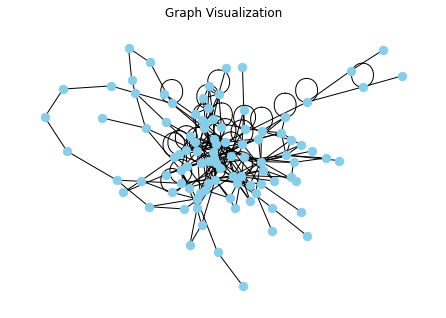

In [60]:
G = nx.from_numpy_array(raw_A[0:100, 0:100])
pos = nx.spring_layout(G)  # 定义节点的布局
nx.draw(G, pos, font_weight='bold', node_size=70, node_color='skyblue', font_color='black', font_size=10)
plt.title("Graph Visualization")
plt.show()

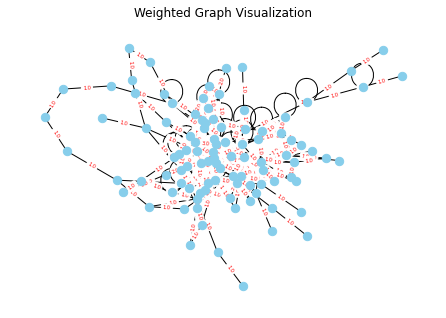

In [65]:
edge_labels = {(i, j): w['weight'] for i, j, w in G.edges(data=True)}
nx.draw(G, pos, font_weight='bold', node_size=70, node_color='skyblue', font_color='black', font_size=5)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=5)

plt.title("Weighted Graph Visualization")
plt.show()

In [96]:
# print(len(user_id2idx_dict))
user_idx = [idx for idx in range(len(user_id2idx_dict))]
input = torch.LongTensor([user_idx]).to(device=args.device)
user_embeddings = user_embed_model(input)
user_embeddings = torch.squeeze(user_embeddings)
user_embeddings = user_embeddings.detach().cpu().numpy()
reverse_dict = {v: k for k, v in user_id2idx_dict.items()}
print(user_idx)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

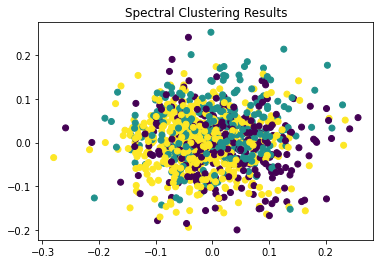

In [120]:
from sklearn.cluster import SpectralClustering
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# # 生成示例数据
# X, y = make_blobs(n_samples=300, centers=3, random_state=42)

X = user_embeddings

# 使用谱聚类
spectral = SpectralClustering(n_clusters=3, affinity='rbf', random_state=42)
labels = spectral.fit_predict(X)

# 绘制结果
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.title('Spectral Clustering Results')
plt.show()

In [136]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

measure = []
cls_n = []

for i in range(2, 31):
    X = user_embeddings

    # 使用谱聚类
    # spectral = SpectralClustering(n_clusters=i, affinity='rbf', random_state=42)
    spectral = DBSCAN(min_samples=i, metric='euclidean')
    labels = spectral.fit_predict(X)

    silavg = silhouette_score(X, labels)
    
    print(i, silavg)
    
    measure.append(silavg)
    cls_n.append(i)
    
    
print(measure)

2 -0.20165941
3 -0.20215474
4 -0.18237944
5 -0.18412301
6 -0.18412301
7 -0.18539459
8 -0.18753502
9 -0.18753502
10 -0.18753502
11 -0.19404103
12 -0.19404103
13 -0.1951003
14 -0.1951003
15 -0.1951003
16 -0.1951003
17 -0.1951003
18 -0.1951003
19 -0.1951003
20 -0.1951003
21 -0.1951003
22 -0.1951003
23 -0.1951003
24 -0.1951003
25 -0.1951003
26 -0.1951003
27 -0.1951003
28 -0.1951003
29 -0.1951003
30 -0.1951003
[-0.20165941, -0.20215474, -0.18237944, -0.18412301, -0.18412301, -0.18539459, -0.18753502, -0.18753502, -0.18753502, -0.19404103, -0.19404103, -0.1951003, -0.1951003, -0.1951003, -0.1951003, -0.1951003, -0.1951003, -0.1951003, -0.1951003, -0.1951003, -0.1951003, -0.1951003, -0.1951003, -0.1951003, -0.1951003, -0.1951003, -0.1951003, -0.1951003, -0.1951003]


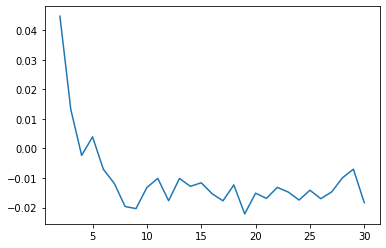

In [130]:
plt.plot(cls_n, measure)

In [130]:
print(user_embedding.shape)

torch.Size([1047, 128])


In [67]:
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

# 计算余弦相似度矩阵
# user_embeddings = user_embeddings.detach().cpu().numpy()

similarity_matrix = cosine_similarity(user_embeddings)

# 构建图
G = nx.Graph()

# 添加节点和边 （只展示前10个）
# num_users = user_embeddings.shape[0]
num_users = 10
for i in range(num_users):
    G.add_node(i)

for i in range(num_users):
    for j in range(i + 1, num_users):
        similarity_score = similarity_matrix[i, j]
        G.add_edge(i, j, weight=similarity_score)

torch.Size([4980, 4980])


Sigma(nx.Graph with 20 nodes and 29 edges)

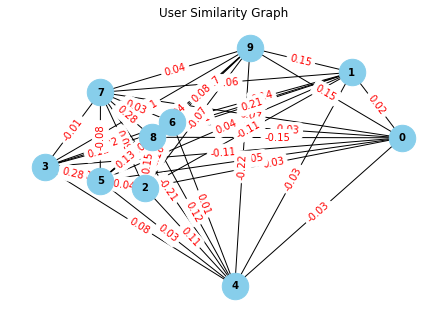

In [132]:
# 绘制图形
pos = nx.spring_layout(G)
edge_labels = {(i, j): f'{G[i][j]["weight"]:.2f}' for i, j in G.edges()}
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', font_color='black', font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title("User Similarity Graph")
plt.show()

In [147]:
# 选择一个用户（例如，用户0）
target_user_index = 10
target_user_embedding = user_embeddings[target_user_index]

# 计算余弦相似度
similarities = cosine_similarity([target_user_embedding], user_embeddings)[0]

# 排序相似度，找到最相似的三个用户的索引
most_similar_indices = np.argsort(similarities)[::-1][1:4]  # 排除自身，选择前三个最相似的用户

print(most_similar_indices)

similar_user_id = [reverse_dict[idx] for idx in most_similar_indices]

target_user_id = reverse_dict[target_user_index]

print(similar_user_id, target_user_id)

[952 367 126]
['982', '374', '132'] 12


In [97]:
from sklearn.metrics.pairwise import cosine_similarity
user_idx = [idx for idx in range(len(user_id2idx_dict))]

similar_users = []

target_users = []

for target_user_index in range(user_embeddings.shape[0]):
    # 选择一个用户（例如，用户0）
    target_user_embedding = user_embeddings[target_user_index]

    # 计算余弦相似度
    similarities = cosine_similarity([target_user_embedding], user_embeddings)[0]

    # 排序相似度，找到最相似的三个用户的索引
    most_similar_indices = np.argsort(similarities)[::-1][1:4]  # 排除自身，选择前三个最相似的用户

    similar_user_id = [int(reverse_dict[idx]) for idx in most_similar_indices]
    
    similar_users.append(similar_user_id)

    target_user_id = int(reverse_dict[target_user_index])
    
    target_users.append(target_user_id)
    
similar_users = np.array(similar_users)

target_users = np.array(target_users)

In [98]:
print(target_users)

[   1    2    3 ... 1080 1082 1083]


In [99]:
import csv

# Assuming similar_users is a list of lists
data = list(zip(target_users, similar_users[:, 0], similar_users[:, 1], similar_users[:, 2]))

# Specify the CSV file path
csv_file_path = "similar_users_2.csv"

# Writing to CSV file
with open(csv_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    
    # Write header
    writer.writerow(["user_idx", "similar_user_1", "similar_user_2", "similar_user_3"])
    
    # Write data
    for row in data:
        writer.writerow(row)

print(f"CSV file saved at: {csv_file_path}")

CSV file saved at: similar_users_2.csv


In [77]:
# print(similar_users)
# print(user_idx)

In [78]:
similar_dict = list(zip(user_idx, similar_users[:, 0], similar_users[:, 1], similar_users[:, 2]))
print(similar_dict)

[(0, 117, 760, 345), (1, 858, 570, 407), (2, 79, 530, 1027), (3, 801, 257, 725), (4, 556, 636, 916), (5, 690, 801, 4), (6, 717, 25, 605), (7, 462, 927, 214), (8, 1005, 650, 451), (9, 747, 47, 117), (10, 1012, 552, 992), (11, 752, 698, 542), (12, 96, 130, 98), (13, 462, 566, 173), (14, 314, 531, 902), (15, 300, 977, 28), (16, 502, 594, 978), (17, 621, 950, 391), (18, 939, 765, 870), (19, 544, 899, 875), (20, 64, 558, 841), (21, 744, 309, 271), (22, 25, 250, 8), (23, 8, 570, 24), (24, 1067, 305, 224), (25, 529, 435, 1068), (26, 959, 597, 839), (27, 369, 653, 812), (28, 339, 328, 1011), (29, 576, 194, 82), (30, 982, 1036, 158), (31, 115, 493, 848), (32, 143, 524, 1014), (33, 294, 76, 643), (34, 1002, 607, 610), (35, 800, 829, 812), (36, 76, 401, 449), (37, 286, 1031, 778), (38, 107, 692, 769), (39, 71, 830, 897), (40, 1028, 1037, 172), (41, 1067, 590, 920), (42, 605, 186, 1063), (43, 844, 504, 395), (44, 369, 423, 938), (45, 161, 218, 115), (46, 997, 756, 173), (47, 938, 89, 553), (48, 14

In [94]:
data_idx = 240
target_data = similar_dict[data_idx]
target_user = target_data[0]
target_sim_1 = target_data[1]
target_sim_2 = target_data[2]
target_sim_3 = target_data[3]

In [95]:
target_user_cat = list(train_df[train_df['user_id'] == target_user]['POI_catname'])
text_data = target_user_cat
text_data_str = ' '.join(text_data)
print(text_data_str)

target_sim_cat_1 = list(train_df[train_df['user_id'] == target_sim_1]['POI_catname'])
text_data = target_sim_cat_1
text_data_str = ' '.join(text_data)
print(text_data_str)

target_sim_cat_2 = list(train_df[train_df['user_id'] == target_sim_2]['POI_catname'])
text_data = target_sim_cat_2
text_data_str = ' '.join(text_data)
print(text_data_str)

target_sim_cat_3 = list(train_df[train_df['user_id'] == target_sim_3]['POI_catname'])
text_data = target_sim_cat_3
text_data_str = ' '.join(text_data)
print(text_data_str)

Café Office Office Café Café Café Office College Academic Building Café Office Office Café Office Office Sandwich Place Beer Garden Food & Drink Shop Ferry Other Great Outdoors Café Office Café Office Café Office Café Office Office Movie Theater Café Office Café Office Café Office
Bar Bar Gym / Fitness Center Performing Arts Venue Italian Restaurant Office Gym / Fitness Center Gym / Fitness Center Movie Theater Gym / Fitness Center
Event Space Event Space Park Event Space Food & Drink Shop Coffee Shop Event Space Taco Place Park Event Space Food & Drink Shop Music Venue Café Event Space Park Event Space Event Space Park Music Venue Event Space Park Food Truck Movie Theater Food Truck Event Space Event Space Performing Arts Venue Park Event Space Event Space Food Truck Movie Theater Event Space Event Space Event Space Food Truck Park Event Space Event Space Neighborhood Park Event Space BBQ Joint Event Space Park Event Space Park Café Event Space
Electronics Store Art Museum Garden Elec

In [90]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 输入文本数据，可以是字符串或列表
text_data = target_user_cat

text_data_str = ' '.join(text_data)

print(text_data_str)

# # 创建WordCloud对象
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data_str)

# # 可以选择设置其他参数，例如字体、最大词数等
# # wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100, font_path='path/to/font.ttf').generate(text_data)

# w=WordCloud(background_color="white")
# w.generate(text_data_str)
# w.to_file("pywcloud.png")

# # 绘制词云图
# plt.figure(figsize=(10, 5))
# plt.imshow(w, interpolation='bilinear')
# plt.axis('off')  # 不显示坐标轴
# plt.show()

Café Office Office Café Café Café Office College Academic Building Café Office Office Café Office Office Sandwich Place Beer Garden Food & Drink Shop Ferry Other Great Outdoors Café Office Café Office Café Office Café Office Office Movie Theater Café Office Café Office Café Office


ValueError: Only supported for TrueType fonts

In [148]:
import community  # python-louvain库

In [171]:
similarity_matrix = np.clip(np.dot(user_embeddings, user_embeddings.T), 0, None)
graph = nx.Graph(similarity_matrix)

# 使用python-louvain进行社团划分
partition = community.best_partition(graph)

In [172]:
commuity_user = []
for i in range(len(partition)):
    commuity_user.append(partition[i])
    
print(commuity_user)

[4, 1, 4, 4, 1, 4, 4, 4, 4, 4, 1, 3, 4, 4, 3, 4, 4, 3, 2, 2, 4, 4, 0, 4, 0, 3, 1, 1, 3, 1, 4, 3, 3, 3, 4, 1, 4, 0, 1, 4, 1, 3, 1, 2, 4, 4, 0, 1, 0, 0, 3, 4, 4, 4, 0, 4, 3, 3, 2, 4, 4, 4, 3, 1, 1, 1, 3, 3, 1, 2, 1, 3, 0, 3, 3, 4, 4, 0, 1, 3, 0, 1, 4, 3, 0, 1, 4, 4, 2, 1, 0, 1, 3, 2, 0, 4, 3, 2, 0, 4, 3, 3, 3, 1, 4, 0, 3, 4, 2, 4, 4, 4, 2, 4, 1, 3, 3, 3, 0, 3, 4, 4, 0, 0, 1, 4, 0, 4, 4, 4, 4, 0, 3, 1, 4, 4, 0, 3, 3, 4, 3, 1, 4, 4, 1, 1, 4, 4, 3, 0, 2, 0, 4, 0, 4, 4, 0, 0, 4, 4, 4, 0, 3, 0, 4, 4, 1, 3, 4, 4, 2, 4, 1, 3, 3, 1, 4, 2, 3, 3, 3, 3, 0, 2, 0, 3, 4, 4, 4, 0, 4, 4, 2, 0, 3, 1, 4, 1, 3, 0, 3, 4, 3, 2, 3, 0, 0, 4, 3, 3, 0, 4, 4, 2, 0, 1, 1, 0, 3, 4, 4, 3, 4, 4, 3, 4, 4, 0, 2, 3, 3, 1, 1, 0, 4, 0, 2, 4, 4, 2, 4, 4, 0, 4, 4, 4, 4, 1, 4, 4, 4, 3, 3, 0, 3, 3, 0, 1, 4, 1, 3, 0, 0, 3, 2, 3, 4, 4, 4, 0, 2, 1, 4, 2, 2, 4, 4, 2, 1, 0, 3, 0, 1, 4, 2, 1, 3, 4, 4, 4, 4, 4, 0, 3, 2, 4, 2, 4, 0, 1, 0, 2, 2, 1, 3, 4, 2, 3, 3, 3, 4, 2, 3, 4, 2, 3, 0, 4, 0, 0, 3, 4, 1, 4, 0, 0, 0, 0, 3, 1, 0, 0, 0, 

/root/miniconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


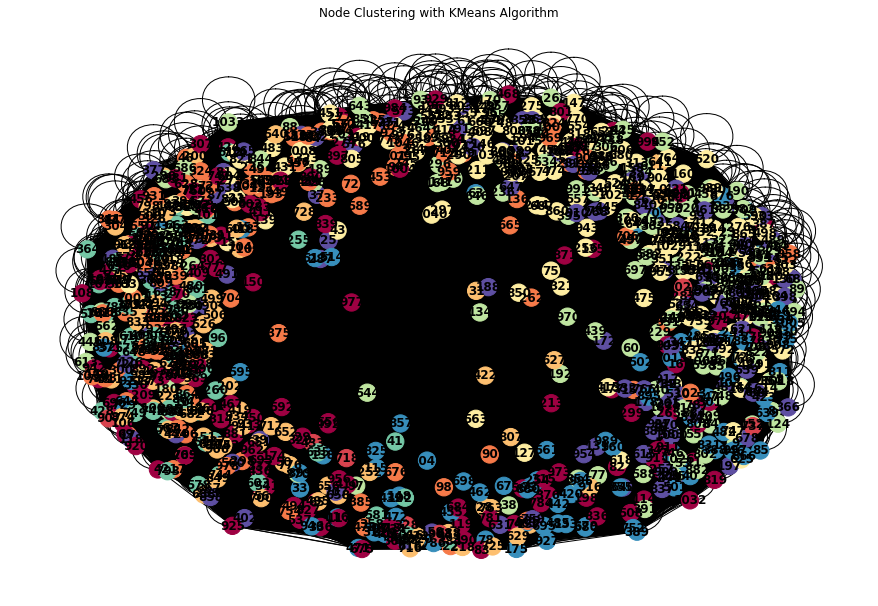

In [154]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

similarity_matrix = np.dot(user_embeddings, user_embeddings.T)
graph = nx.Graph(similarity_matrix)

# 获取节点嵌入
node_features = np.array([user_embeddings[node] for node in graph.nodes])

# 标准化特征（可选）
scaler = StandardScaler()
node_features_scaled = scaler.fit_transform(node_features)

# 使用KMeans进行聚类
num_clusters = 10  # 设置聚类数量
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(node_features_scaled)

# 将聚类结果添加到图的节点属性中
nx.set_node_attributes(graph, dict(zip(graph.nodes, cluster_labels)), 'cluster')

# 绘制图形
pos = nx.spring_layout(graph)
colors = [graph.nodes[node]['cluster'] for node in graph.nodes]

plt.figure(figsize=(12, 8))
nx.draw(graph, pos, node_color=colors, with_labels=True, font_weight='bold', cmap=plt.cm.Spectral)
plt.title("Node Clustering with KMeans Algorithm")
plt.show()

In [186]:
directed_adj_matrix = np.array([[1, 2, 0, 1],
                                [0, 3, 4, 0],
                                [0, 0, 5, 0],
                                [6, 0, 0, 7]])

# 取有向图邻接矩阵的对称部分
undirected_adj_matrix = np.maximum(directed_adj_matrix, directed_adj_matrix.T)

# # 去除自环（将对角线上的元素设置为零）
# np.fill_diagonal(undirected_adj_matrix, 0)

print("有向图邻接矩阵：")
print(directed_adj_matrix)
print("\n无向图邻接矩阵：")
print(undirected_adj_matrix)

有向图邻接矩阵：
[[1 2 0 1]
 [0 3 4 0]
 [0 0 5 0]
 [6 0 0 7]]

无向图邻接矩阵：
[[1 2 0 6]
 [2 3 4 0]
 [0 4 5 0]
 [6 0 0 7]]


In [62]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 输入文本数据，可以是字符串或列表
text_data = "Python is an amazing programming language. Python is widely used for data science."

# 创建WordCloud对象
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# 可以选择设置其他参数，例如字体、最大词数等
# wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100, font_path='path/to/font.ttf').generate(text_data)

# 绘制词云图
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 不显示坐标轴
plt.show()

ModuleNotFoundError: No module named 'wordcloud'

In [15]:
from transformers import BertModel, BertTokenizer
import torch

# 加载预训练的 BERT 模型和分词器
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 输入句子
sentence = "This is an example sentence."

# 分词并添加特殊标记（[CLS] 和 [SEP]）
tokens = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)

# 获取模型输出（last_hidden_state 就是编码）
with torch.no_grad():
    outputs = model(**tokens)

# 获取句子编码
sentence_encoding = outputs.last_hidden_state.mean(dim=1)  # 对句子中所有词的编码取平均

# 输出编码结果
print(sentence_encoding.shape) 

OSError: We couldn't connect to 'https://huggingface.co' to load this file, couldn't find it in the cached files and it looks like bert-base-uncased is not the path to a directory containing a file named config.json.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

/tmp/ipykernel_21166/581745618.py:8: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(raw_A_undirect), cmap='viridis', interpolation='nearest')


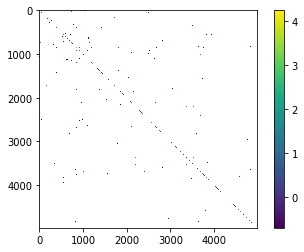

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# 创建一个矩阵（这里使用随机生成的数据）
matrix = np.random.rand(10, 10)

# 绘制热力图
plt.imshow(np.log(raw_A_undirect), cmap='viridis', interpolation='nearest')

# 添加颜色条
plt.colorbar()

# 显示图形
plt.show()

In [47]:
print(np.mean(raw_A), np.max(raw_A))

0.0029114852986242157 75.0


In [50]:
print(torch.diag(A))

tensor([0.1818, 0.3333, 0.2444,  ..., 0.3243, 0.0714, 0.1905], device='cuda:0')


/tmp/ipykernel_21166/1456553378.py:34: RuntimeWarning: divide by zero encountered in log
  heatmap1 = plt.imshow(np.log(raw_A), cmap='viridis', interpolation='nearest')
/tmp/ipykernel_21166/1456553378.py:43: RuntimeWarning: divide by zero encountered in log
  heatmap2 = plt.imshow(np.log(raw_A_undirect), cmap='viridis', interpolation='nearest')


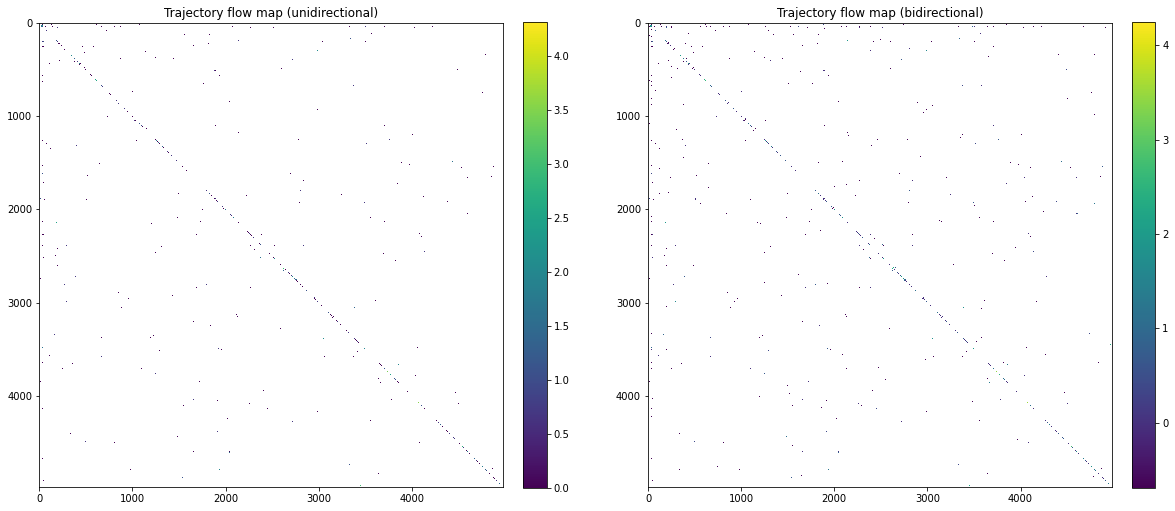

In [194]:
# # 第一个子图
# plt.figure(figsize=(10, 10))

# plt.subplot(1, 2, 1)
# # 绘制热力图
# plt.imshow(np.log(raw_A), cmap='viridis', interpolation='nearest')

# # 添加颜色条
# plt.colorbar()
# plt.title("Trajectory flow map (unidirectional)")

# # 第二个子图
# plt.subplot(1, 2, 2)
# # 绘制热力图
# plt.imshow(np.log(raw_A_undirect), cmap='viridis', interpolation='nearest')

# # 添加颜色条
# plt.colorbar()
# plt.title("Trajectory flow map (bidirectional)")

# plt.savefig("Traj_flow_1.jpg")
import numpy as np
import matplotlib.pyplot as plt

# 创建一个示例矩阵
# raw_A = np.random.rand(10, 10)
# raw_A_undirect = np.random.rand(10, 10)

# 第一个子图
plt.figure(figsize=(20, 25))

plt.subplot(1, 2, 1)
# 绘制热力图
heatmap1 = plt.imshow(np.log(raw_A), cmap='viridis', interpolation='nearest')

# 添加颜色条
cbar1 = plt.colorbar(heatmap1, fraction=0.046, pad=0.04)  # 调整 fraction 和 pad 控制 colorbar 的大小和位置
plt.title("Trajectory flow map (unidirectional)")

# 第二个子图
plt.subplot(1, 2, 2)
# 绘制热力图
heatmap2 = plt.imshow(np.log(raw_A_undirect), cmap='viridis', interpolation='nearest')

# 添加颜色条
cbar2 = plt.colorbar(heatmap2, fraction=0.046, pad=0.04)  # 调整 fraction 和 pad 控制 colorbar 的大小和位置
plt.title("Trajectory flow map (bidirectional)")

plt.savefig("Traj_flow_1.jpg", bbox_inches='tight')

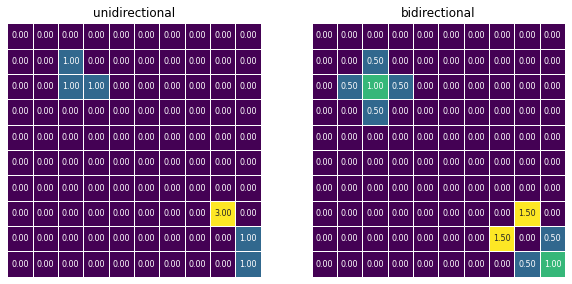

In [191]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

# 创建一个矩阵（这里使用随机生成的数据）
matrix = np.random.rand(10, 10)

# 设置块状展示
block_size = 1  # 设置块的大小
plt.subplot(1, 2, 1)
# 使用 seaborn 的 heatmap 函数
ax = sns.heatmap(raw_A[1120:1130, 1120:1130], cmap='viridis', cbar=False, square=True, annot=True, fmt='.2f', linewidths=.5, annot_kws={"size": 8})
plt.title("unidirectional")
plt.axis("off")
# 获取 colorbar 对象
# cbar = ax.collections[0].colorbar

# 调整 colorbar 大小
# cbar.ax.set_aspect(7)  # 设置宽高比例

plt.subplot(1, 2, 2)
# 使用 seaborn 的 heatmap 函数
ax = sns.heatmap(raw_A_undirect[1120:1130, 1120:1130], cmap='viridis', cbar=False, square=True, annot=True, fmt='.2f', linewidths=.5, annot_kws={"size": 8})
# 显示图形
plt.title("bidirectional")
plt.axis("off")
# plt.show()
plt.savefig("Traj_flow_2.eps", bbox_inches='tight')

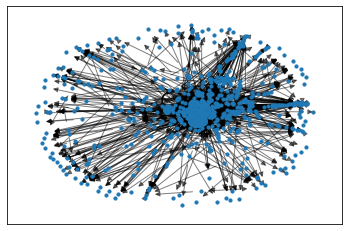

In [24]:
import networkx as nx
import matplotlib.pyplot as plt

# 创建一个大规模图
G = nx.scale_free_graph(1000)

# 使用 Fruchterman-Reingold 布局算法布局节点
pos = nx.spring_layout(G)

# 绘制节点
nx.draw_networkx_nodes(G, pos, node_size=10)

# 绘制边
nx.draw_networkx_edges(G, pos, alpha=0.5)

# 显示图形
plt.show()